$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Wm}{\mathbf{W}}
 \newcommand{\Ym}{\mathbf{Y}}
 \newcommand{\I}{\mathbf{I}}
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
$

# Deep Learning

Deep learning is one of the most popular technologies in machine learning, well not only in ML in IT. There are many sources that shows increasing the popularity and success with deep learning. Here is one of them from Google. 

<img src="https://instinct.radeon.com/wp-content/uploads/sites/4/2017/04/deep-learning-google-1.png" /> 
Source: https://www.slideshare.net/HadoopSummit/machine-intelligence-at-google-scale-tensorflow


Google has exponentially increased the use of deep learning, and this is not only for Google. In many areas, deep learning has suggested the solutions to many difficult or complex problems. Here are some articles that I can save my words for introduction.


- https://www.technologyreview.com/s/513696/deep-learning/
- https://www.wired.com/2014/01/geoffrey-hinton-deep-learning/
- http://fortune.com/ai-artificial-intelligence-deep-machine-learning/


## Going Deep from 2-Layer Neural Network

Previously we learned neural networks and how they can be stacked up into 2-layer neural network. With the codes that I provided, we also build deep neural networks by passing multiple entry with the number of hidden units for each layer. 

Now, let us rewrite the codes with TensorFlow. Neural network with multiple hidden nodes can be computed fast by using multiple processors. By using TensorFlow, we can make our implementaion to be executed in distributed systems or GPU machines. 



In [2]:
# preparation

import tensorflow as tf
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import IPython.display as ipd  # for display and clear_output

In [88]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

Review the NeuralNet class in the Neural Networks and Optimization notes before start this. 

## Training and Testing Data

In [46]:
# Now play with example 
# Make some training data
n = 20
Xtrain = np.linspace(0.,20.0,n).reshape((n,1)) - 10
Ttrain = 0.2 + 0.05 * (Xtrain+10) + 0.4 * np.sin(Xtrain+10) + 0.2 * np.random.normal(size=(n,1))

# Make some testing data
Xtest = Xtrain + 0.1*np.random.normal(size=(n,1))
Ttest = 0.2 + 0.05 * (Xtest+10) + 0.4 * np.sin(Xtest+10) + 0.2 * np.random.normal(size=(n,1))

In [43]:
reset_graph()

# 2 inputs and 1 output
ni = 1
nh = 10
no = 1
learning_rate = 0.1

# inputs for training
X = tf.placeholder(tf.float32, [None, ni])
T = tf.placeholder(tf.float32, [None, no])

V = tf.Variable(tf.truncated_normal([ni+1, nh]))
W = tf.Variable(tf.truncated_normal([nh+1, no]))


In [44]:
# forward pass
#  Y =  h(XV) W

a = tf.matmul(X, V[1:, :]) + V[0, :]
Z = tf.tanh(a)  # activation
Y = tf.matmul(Z, W[1:, :]) + W[0, :]


In [45]:
# backward pass
error = T - Y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

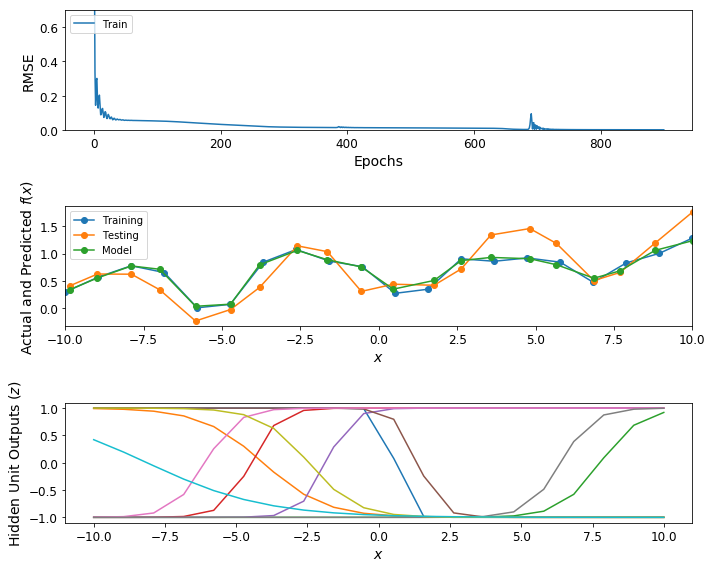

In [56]:
n_epochs = 1000

fig = plt.figure(figsize=(10,8))
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    
    errorTrace = []
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval({X: Xtrain, T: Ttrain}))

            plt.clf()
            plt.subplot(3,1,1)
            plt.plot(errorTrace[:epoch])
            plt.ylim(0,0.7)
            plt.xlabel('Epochs')
            plt.ylabel('RMSE')
            plt.legend(('Train','Test'),loc='upper left')

            plt.subplot(3,1,2)
            plt.plot(Xtrain,Ttrain,'o-',Xtest,Ttest,'o-',Xtest,Y.eval({X: Xtest}),'o-')
            plt.xlim(-10,10)
            plt.legend(('Training','Testing','Model'),loc='upper left')
            plt.xlabel('$x$')
            plt.ylabel('Actual and Predicted $f(x)$')

            plt.subplot(3,1,3)
            plt.plot(Xtrain, Z.eval({X: Xtrain}))
            plt.ylim(-1.1,1.1)
            plt.xlabel('$x$')
            plt.ylabel('Hidden Unit Outputs ($z$)');
            
            plt.tight_layout()

            ipd.clear_output(wait=True)
            ipd.display(fig)            
            
        err, _ = sess.run([mse, training_op], {X: Xtrain, T: Ttrain})
        errorTrace.append(err)
    

    print("Train MSE: ", mse.eval({X: Xtrain, T: Ttrain}))
    print("Test MSE: ", mse.eval({X: Xtest, T: Ttest}))
ipd.clear_output(wait=True)

# Module: tf.layers

There is a module for high level neural networks layers. 
Here are the link to the reference: https://www.tensorflow.org/api_docs/python/tf/layers. 

With this built-in module, we can easily stack layers to build neural networks. 

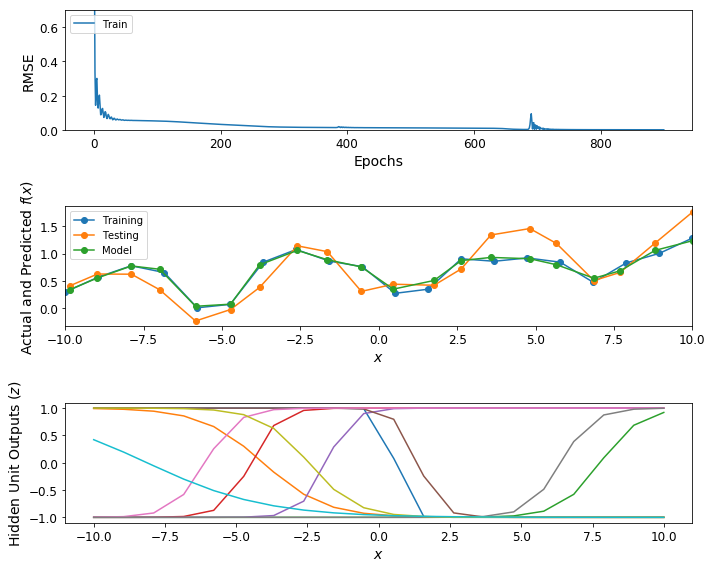

In [55]:
# with layers to build networks 

reset_graph()
ni = 1
nh = 10
no = 1
learning_rate = 0.1

# inputs for training
X = tf.placeholder(tf.float32, [None, ni])
T = tf.placeholder(tf.float32, [None, no])

# neural network building 
with tf.name_scope("nn"):
    Z = tf.layers.dense(X, nh, activation=tf.tanh, name="h1")
    Y = tf.layers.dense(Z, no, name="out")

with tf.name_scope("loss"):
    error = T - Y
    mse = tf.reduce_mean(tf.square(error), name="mse")
    
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(mse)
    
n_epochs = 1000

fig = plt.figure(figsize=(10,8))
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    
    errorTrace = []
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval({X: Xtrain, T: Ttrain}))

            plt.clf()
            plt.subplot(3,1,1)
            plt.plot(errorTrace[:epoch])
            plt.ylim(0,0.7)
            plt.xlabel('Epochs')
            plt.ylabel('RMSE')
            plt.legend(('Train','Test'),loc='upper left')

            plt.subplot(3,1,2)
            plt.plot(Xtrain,Ttrain,'o-',Xtest,Ttest,'o-',Xtest,Y.eval({X: Xtest}),'o-')
            plt.xlim(-10,10)
            plt.legend(('Training','Testing','Model'),loc='upper left')
            plt.xlabel('$x$')
            plt.ylabel('Actual and Predicted $f(x)$')

            plt.subplot(3,1,3)
            plt.plot(Xtrain, Z.eval({X: Xtrain}))
            plt.ylim(-1.1,1.1)
            plt.xlabel('$x$')
            plt.ylabel('Hidden Unit Outputs ($z$)');

            plt.tight_layout()
            ipd.clear_output(wait=True)
            ipd.display(fig)            
            
        err, _ = sess.run([mse, training_op], {X: Xtrain, T: Ttrain})
        errorTrace.append(err)
    

    print("Train MSE: ", mse.eval({X: Xtrain, T: Ttrain}))
    print("Test MSE: ", mse.eval({X: Xtest, T: Ttest}))
ipd.clear_output(wait=True)

# Going Deeper with TF

In [ ]:
# You can go deep by stacking the dense (full-connected) layers

reset_graph()
ni = 1
nh = 10
no = 1
learning_rate = 0.1

# inputs for training
X = tf.placeholder(tf.float32, [None, ni])
T = tf.placeholder(tf.float32, [None, no])

# neural network building 
with tf.name_scope("nn"):
    Z = tf.layers.dense(X, nh, activation=tf.tanh, name="h1")
    Y = tf.layers.dense(Z, no, name="out")

with tf.name_scope("loss"):
    error = T - Y
    mse = tf.reduce_mean(tf.square(error), name="mse")
    
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(mse)

# Training Deep Nets

## Initialization

[Glorot and Bengio](http://proceedings.mlr.press/v9/glorot10a.html) discussed about how we can initialize the weights to ensure deep networks not to have the vanishing gradient problem. The basic idea of it was how to make the neural networks to have equal variance for the outputs to the inputs. Later, [He, et al.](https://arxiv.org/abs/1502.01852), also suggested an efficient initialization for the ReLU activation functions. 

Here follows the table from the text. 

<img src="http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/nn_init.png" width=600 />

In TensorFlow, the Xavier initialization is default. To select a He initialization, you can use this code. 

In [69]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

## Activation Function

Previously, we have discussed about various choice of activation functions briefly.
In deep networks, vanishing or exploding gradient problems were in part due to a poor choice of activation function.
The s-shape curves like logistic sigmoid or tanh saturates to when inputs become very large. This can result in nearly zero derivative, which affects other layers' gradient. ReLU, the Rectifier Linear Unit, does not have any positive saturation with simple and fast gradient (0 or 1). 
However, ReLU has well-known *dying ReLU* problem that always outputs 0. Since the gradient of ReLU for negative inputs are 0, it is unlikely to be recovered when a ReLU is dead. 
Leaky ReLU suggests a solution by allowing leaks for negative inputs. That is, now you have a slope, typically 0.01, for the negatives. 
Now, let us take a look at the activation functions in the following codes.


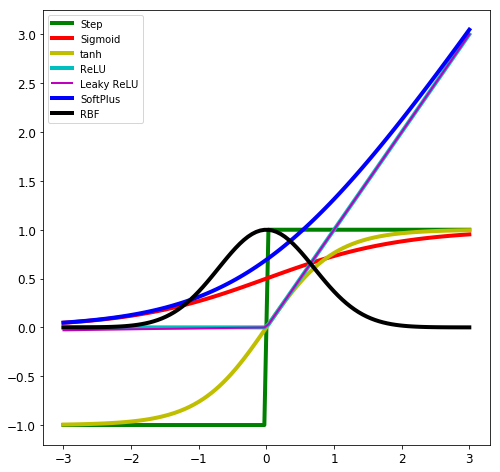

In [3]:
# Activation Functions

def step(x):
    return 1 if x > 0 else -1

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return x if x > 0 else 0

def leak_relu(x):
    return x if x > 0 else 0.01 * x

def softplus(x):
    return np.log(1+np.exp(x))

def gauss(x):
    return np.exp(-x**2)

COLORS=['g','r','y','c','m','b','k']
LABELS=['Step','Sigmoid','tanh','ReLU','Leaky ReLU','SoftPlus','RBF']
x = np.linspace(-3, 3, 100)

plt.figure(figsize=(8,8))
for i, f in enumerate([step, sigmoid, tanh, relu, leak_relu, softplus, gauss]):
     plt.plot(x, list(map(f,x)), color=COLORS[i], linewidth=4 if i!=4 else 2, label=LABELS[i])

plt.legend()

Our text discuss more choices that extends ReLU, including ELU (Exponential Linear Unit). This has been improved training time and better performance on the test data. 

$$
ELU_\alpha (z) = \begin{cases}
    \alpha( \exp(z) - 1)      & \quad \text{if } z < 0\\
    z  & \quad \text{if } z \ge 0
  \end{cases}
$$

The negative outputs for negative inputs help a hidden unit to produce outputs centered to zero. This helps speed up learning. Also, similar to Leaky ReLU, the nonzero gradient for negetive inputs avoids the dying ReLU. 

In [58]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

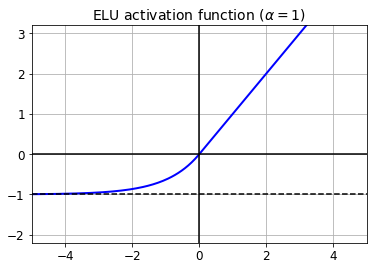

In [61]:
z = np.linspace(-5, 5, 200)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017 (I will definitely add it to the book). It outperforms the other activation functions very significantly for deep neural networks, so you should really try it out.

According to the author of our text, this activation function preserves the mean 0 and standard deviation 1 across all layers of neural networks with 100 layers. That is amzaing! 

In [63]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

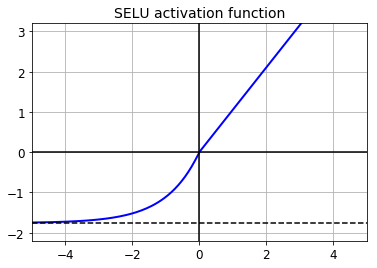

In [65]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

Now, let us try this in TensorFlow. 

In [76]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))



In [ ]:
# to use SELU activation, you just need to create the dense layer with activation parameter!
### DO NOT RUN THIS #####
hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")

This cell does not work since it only highlights the interesting part. 
In a complete example for MNIST data, the neural network can be created as below. 

In [77]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

In [78]:
# loading data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [79]:
means = mnist.train.images.mean(axis=0, keepdims=True)
stds = mnist.train.images.std(axis=0, keepdims=True) + 1e-10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            X_val_scaled = (mnist.validation.images - means) / stds
            acc_test = accuracy.eval(feed_dict={X: X_val_scaled, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.88 Validation accuracy: 0.9232
5 Batch accuracy: 0.98 Validation accuracy: 0.9566
10 Batch accuracy: 1.0 Validation accuracy: 0.9658
15 Batch accuracy: 1.0 Validation accuracy: 0.9698
20 Batch accuracy: 0.98 Validation accuracy: 0.9706
25 Batch accuracy: 1.0 Validation accuracy: 0.9692
30 Batch accuracy: 1.0 Validation accuracy: 0.9702
35 Batch accuracy: 1.0 Validation accuracy: 0.9698


## Batch Normalization

Ioffe and Szegedy proposed a batch normalization technique to avoid the vanishing gradient problem. Unlike the standard normalization, it has minibatch normalization on each layer. 
That is, before applying an activation function, it applies normalization of the data, centering to zero and normalizing, scaling and shifting the inputs. 

Here follows the codes for it.

In [81]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

Borrowing the codes from the text, we can have the batch normalized version as below:

In [114]:
reset_graph()

from functools import partial

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()  # for reuse

In [116]:
n_epochs = 20
batch_size = 200

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    # codes for reuse - will talk in next section
    for op in (X, y, accuracy, training_op):
        tf.add_to_collection("my_important_ops", op)
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.8719
1 Test accuracy: 0.8965
2 Test accuracy: 0.9109
3 Test accuracy: 0.9222
4 Test accuracy: 0.9272
5 Test accuracy: 0.9345
6 Test accuracy: 0.9374
7 Test accuracy: 0.9406
8 Test accuracy: 0.946
9 Test accuracy: 0.9476
10 Test accuracy: 0.9507
11 Test accuracy: 0.9528
12 Test accuracy: 0.9545
13 Test accuracy: 0.9555
14 Test accuracy: 0.9571
15 Test accuracy: 0.9595
16 Test accuracy: 0.96
17 Test accuracy: 0.9615
18 Test accuracy: 0.9634
19 Test accuracy: 0.9621


# Reusing Pretrained Layers! 

Often, the training deep network requires a fair amount of time. For similar problems, instead of training a very large deep network from scratch, you can always reuse old networks for similar problems. 

<img src="http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/nn_reuse.png" width=600 />

In [117]:
reset_graph()
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [118]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
training/input
training
hidden1/kernel/Initializer/truncated_normal/shape
hidden1/kernel/Initializer/truncated_normal/mean
hidden1/kernel/Initializer/truncated_normal/stddev
hidden1/kernel/Initializer/truncated_normal/TruncatedNormal
hidden1/kernel/Initializer/truncated_normal/mul
hidden1/kernel/Initializer/truncated_normal
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/Const
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
batch_normalization/beta/Initializer/Const
batch_normalization/beta
batch_normalization/beta/Assign
batch_normalization/beta/read
batch_normalization/gamma/Initializer/Const
batch_normalization/gamma
batch_normalization/gamma/Assign
batch_normalization/gamma/read
batch_normalization/moving_mean/Initializer/Const
batch_normalization/moving_mean
batch_normalization/moving_mean/Assign
batch_normalization/moving_mean/read
batch_normalization/moving_variance/Initializer/Const
batch_normalizat

In [109]:
show_graph(tf.get_default_graph())

Now, we need a tensor (data) or an op (operation) before using the networks.

In [119]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

This add/get collection makes easy to restore the networks than this codes.

> X = tf.get_default_graph().get_tensor_by_name("X:0") 

> y = tf.get_default_graph().get_tensor_by_name("y:0")

> accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

>training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [120]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")  

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9638
1 Test accuracy: 0.9655
2 Test accuracy: 0.9657
3 Test accuracy: 0.9671
4 Test accuracy: 0.9672
5 Test accuracy: 0.9679
6 Test accuracy: 0.9689
7 Test accuracy: 0.9693
8 Test accuracy: 0.9692
9 Test accuracy: 0.9698
10 Test accuracy: 0.9702
11 Test accuracy: 0.9701
12 Test accuracy: 0.9706
13 Test accuracy: 0.9701
14 Test accuracy: 0.9708
15 Test accuracy: 0.97
16 Test accuracy: 0.9709
17 Test accuracy: 0.9713
18 Test accuracy: 0.9715
19 Test accuracy: 0.9717


## More tricks...

There are far more tricks are disucssed in our text. Please download the python notebook from the GitHub, practice them by yourself. 


# Regularization

We have discussed about some regularization techniques such as early stopping, regularization, adding noises, and so on. For neural networks, you can consider dropout that turns some hidden nodes with dropout rate (usually 50%) for training. It has successfully generated better model in many practical applications. So you can consider add a line for tf.layers.dropout() call.  

In [ ]:
hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)